In [1]:
#Thomas Egg
#March 27, 2022
#Code to pull in various gaussian outputs, compile spectra, and create ML models

#Importing necessary libraries
import random
import pandas as pd
import numpy as np
import cclib
import math
from matplotlib import pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [2]:
#Defining functions

def freq(file):
    """Returns IR frequencies from Gaussian file input
    
    :param file: the file to read for frequencies
    :rtype: float
    :return: IR frequencies
    """
    for i in range(len(file)):
        filename = file
        parser = cclib.io.ccopen(filename)
        data = parser.parse()
        return data.vibfreqs
    
def inten(file):
    """Returns IR intensities from Gaussian file input
    
    :param file: the file to read for intensities
    :rtype: float
    :return: IR intensities
    """
    for i in range(len(file)):
        filename = file
        parser = cclib.io.ccopen(filename)
        data = parser.parse()
        return data.vibirs
    
def specManifest(freq,inten,broad):
    """Creates a spectrum from IR frequencies and intensities
    
    :param freq: IR frequencies
    :type: float
    :param inten: Corresponding IR intensities
    :type: float
    :param broad: Broadening factor by which to broaden spectral peaks
    :type: int
    :rtype: array
    :return: array of spectral points in 1000 to 4000 nm frequency range
    """
    x = np.arange(1000, 4001, 1)
    y = [0]*3001
    z = 0
    
    for i in range(len(x)):
        z = 0
        for j in range(len(inten)):
            z = z + (inten[j]*(1/math.sqrt(2*math.pi*(broad**2))*math.exp(-1/2*((x[i]-freq[j])**2)/(broad))**2))
        y[i] = z
    
    toUse = np.array(y)
    final = np.zeros(3001)
    
    for k in range(np.size(toUse)):
        final[k] = (toUse[k]-np.min(toUse))/(np.max(toUse)-np.min(toUse))
        
    return final

def grabGauss(num,conc):
    """Function that takes in spectral points of individual components and creates an array of mixture spectra
    
    :param num: number of mixture spectra to create
    :type: int
    :param conc: array of concentrations (by mole fraction)
    :type: array
    :rtype: array
    :return: array of mixture spectra
    """
    parent = os.getcwd()
    finalArr = [[0 for i in range(3001)] for j in range(num)]
    initArr = [[0 for i in range(3001)] for j in range(3)]
    for i in range(num):
        os.chdir('Dielec_'+str(num))
        initArr[0] = specManifest(freq("Water.out"), inten("Water.out"), 100)
        initArr[1] = specManifest(freq("Methanol.out"), inten("Methanol.out"), 100)
        initArr[2] = specManifest(freq("Ethanol.out"), inten("Ethanol.out"), 100)
        finalArr[i] = np.dot(concArr[i], initArr)
        finalArr[i] = (finalArr[i]-np.min(finalArr[i]))/(np.max(finalArr[i])-np.min(finalArr[i]))
        os.chdir(parent)
    os.chdir(parent)
    return finalArr
def introduceNoise(arr):
    """Introduces noise to simulate real spectral data
    
    :param arr: array of spectral points
    :type: array
    :rtype: array
    :return: array of noise-altered spectral points
    """
    for i in range(100):
        for j in range(3001):
            arr[i][j] += random.uniform(-0.05, 0.05)
    return arr       

def concLabelsMix(num):
    """Creates an array of labelled mixtures by number
    
    :param num: number of mixtures to label
    :type: int
    :rtype: array
    :return: array of strings
    """
    hold = []
    for i in range(num):
        hold.append("Mixture "+str(i+1))
    return hold

In [3]:
#Using some function to create mixture spectral data

pre = open('Concentrations.csv', 'r')
concArr = np.loadtxt(pre, delimiter=',')
pre.close()

bigArr = introduceNoise(grabGauss(1000, concArr))

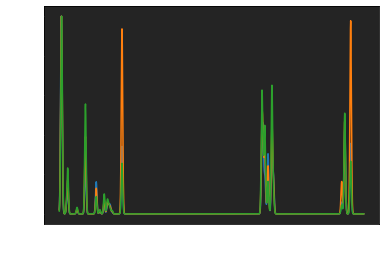

In [4]:
#Plots to check out how our spectra look

font = {
    'family': 'arial',
    'color': 'white',
    'weight': 'normal',
    'size': 12,
}

plt.rcParams['axes.facecolor'] = '.14'
plt.plot(np.arange(1000,4001,1),bigArr[800])
plt.plot(np.arange(1000,4001,1),bigArr[640])
plt.plot(np.arange(1000,4001,1),bigArr[480])
plt.xlabel('Wavelength (nm)', fontdict=font), 
plt.ylabel('Absorbance (normalized)', fontdict=font)
plt.tick_params(axis='x',colors='white')
plt.tick_params(axis='y',colors='white')
plt.show()

In [6]:
#Creating a dataframe of spectral data and concentrations

freqHeaders = np.arange(1000,4001,1)
concHeaders = ['Water x', 'Methanol x', 'Ethanol x']

specFrame = pd.DataFrame(bigArr, columns=freqHeaders)
concFrame = pd.DataFrame(concArr, columns=concHeaders)
mixFrame = pd.concat([specFrame, concFrame], axis=1)
mixFrame.index = concLabelsMix(1000)

X = np.array(mixFrame[freqHeaders])
y = np.array(mixFrame[concHeaders])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

In [8]:
#ML Modeling and analysis
#No PCA

print('\033[1m' + "ML with NO PCA" + '\033[0m')

reg1 = linear_model.Ridge(alpha=1)
reg1.fit(X_train, y_train)
print("Ridge Regression Accuracy: " + str(reg1.score(X_test, y_test)))

reg2 = DecisionTreeRegressor()
reg2.fit(X_train, y_train)
print("Decision Tree Regressor Accuracy: " + str(reg2.score(X_test, y_test)))

reg3 = RandomForestRegressor()
reg3.fit(X_train, y_train)
print("RF Regressor Accuracy: " + str(reg3.score(X_test, y_test)))

ML with NO PCA
Ridge Regression Accuracy: 0.972120494831624
Decision Tree Regressor Accuracy: 0.937030456571137
RF Regressor Accuracy: 0.9818953360254582


In [9]:
#Test out predictions with the scikit predict function

print(concFrame.iloc[[999]])
print(reg1.predict(specFrame.iloc[[999]]))

      Water x  Methanol x  Ethanol x
999  0.158876    0.474497   0.366627
[[0.14165974 0.47432534 0.38401492]]


In [10]:
#Creating models for non-PCM model IR calculations

pureWaterSpec = specManifest(freq("WaterPure.out"), inten("WaterPure.out"), 100)
pureMethanolSpec = specManifest(freq("MethanolPure.out"), inten("MethanolPure.out"), 100)
pureEthanolSpec = specManifest(freq("EthanolPure.out"), inten("EthanolPure.out"), 100)

pureSpecArr = np.array([pureWaterSpec,pureMethanolSpec,pureEthanolSpec])
pureConcArr = concArr
pureFinalArr = np.dot(pureConcArr,pureSpecArr)

for j in range(1000):
    for i in range(3001):
        pureFinalArr[j][i] = (pureFinalArr[j][i]-np.min(pureFinalArr[j]))/(np.max(pureFinalArr[j])-np.min(pureFinalArr[j]))
pureFinalArr = introduceNoise(pureFinalArr)
        
pureSpecFrame = pd.DataFrame(pureFinalArr, columns=freqHeaders)
pureConcFrame = pd.DataFrame(pureConcArr, columns=concHeaders)
pureFinalFrame = pd.concat([pureSpecFrame, pureConcFrame], axis=1)
pureFinalFrame.index = concLabelsMix(1000)

pureFinalFrame.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,3994,3995,3996,3997,3998,3999,4000,Water x,Methanol x,Ethanol x
Mixture 1,-0.003907,0.019323,-0.044621,0.008948,0.052034,0.033878,0.017027,0.040759,0.048455,0.046042,...,0.036328,-0.011391,-0.009967,-0.046507,-0.042342,-0.013259,-0.044414,0.413106,0.037679,0.549216
Mixture 2,-0.014014,0.023239,0.046438,0.032820,-0.018155,-0.014984,0.048820,-0.008603,0.027697,-0.010203,...,0.020777,-0.044692,0.009543,-0.040598,-0.019068,0.029737,-0.001187,0.247981,0.104903,0.647116
Mixture 3,-0.037166,-0.026694,-0.031533,-0.035675,-0.003926,-0.005134,0.036687,-0.025720,-0.024071,0.001350,...,-0.022091,0.000248,0.019475,0.029913,-0.018690,-0.030396,0.032866,0.208185,0.733071,0.058743
Mixture 4,0.045775,-0.024855,0.011300,0.020214,0.022086,0.012259,-0.013416,-0.047006,-0.011486,0.015438,...,0.001733,0.033355,0.037945,0.028542,-0.029108,0.021636,-0.035618,0.580604,0.266352,0.153045
Mixture 5,-0.016547,0.019627,0.028169,-0.018534,0.026123,0.010308,-0.019374,0.046237,0.026862,0.042170,...,-0.012908,0.002756,-0.033559,0.012044,0.006680,-0.000864,-0.039804,0.006889,0.097000,0.896110


In [11]:
#Models for pure spectra dot product method (non-PCM) tested against PCM testing data
#No PCA

print('\033[1m' + "ML with NO PCA: " + '\033[0m' + "Pure Spec Models Tested Against PCM Spec Data")
X2 = np.array(pureFinalFrame[freqHeaders])
y2 = np.array(pureFinalFrame[concHeaders])

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.8)

reg1P = linear_model.Ridge(alpha=1)
reg1P.fit(X2_train, y2_train)
print("Linear Regression Accuracy: " + str(reg1P.score(X_test, y_test)))

reg2P = DecisionTreeRegressor()
reg2P.fit(X2_train, y2_train)
print("Decision Tree Regressor Accuracy: " + str(reg2P.score(X_test, y_test)))

reg3P = RandomForestRegressor()
reg3P.fit(X2_train, y2_train)
print("RF Regressor Accuracy: " + str(reg3P.score(X_test, y_test)))

ML with NO PCA: Pure Spec Models Tested Against PCM Spec Data
Linear Regression Accuracy: 0.531204541425491
Decision Tree Regressor Accuracy: 0.061066971410507986
RF Regressor Accuracy: 0.1829329004633599
